This notebook provides a test walkthrough of the sentiment analysis pipeline.

## Setup and Imports

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append('..')

from src.data_loader import load_amazon_reviews
from src.preprocessor import prepare_review_data, TextPreprocessor
from src.tfidf_model import TFIDFSentimentAnalyzer
from src.llm_model import LLMSentimentAnalyzer
from src.visualizer import SentimentVisualizer
from src.summarizer import CustomerInsightSummarizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)


In [2]:
# Load Amazon reviews
df = load_amazon_reviews(category='Electronics', n_samples=1000)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Reading reviews: 1000it [00:00, 87873.79it/s]

Loaded 1000 reviews
Dataset shape: (1000, 10)

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline so if you are sensitive/allergic to petroleum prod...,"[{'small_image_url': 'https://m.media-amazon.com/images/I/71YN+Qk3kCL._SL256_.jpg', 'medium_imag...",B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True
1,1.0,Didn’t work at all lenses loose/broken.,"These didn’t work. Idk if they were damaged in shipping or what, but the lenses were loose or so...",[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True
2,5.0,Excellent!,I love these. They even come with a carry case and several sizes of ear bud inserts. Thank heave...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for school that would allow me to carry my laptop as well ...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times because I love them so much and overuse them and find w...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True


Rating Distribution:
rating
1.0     90
2.0     35
3.0     65
4.0    145
5.0    665
Name: count, dtype: int64


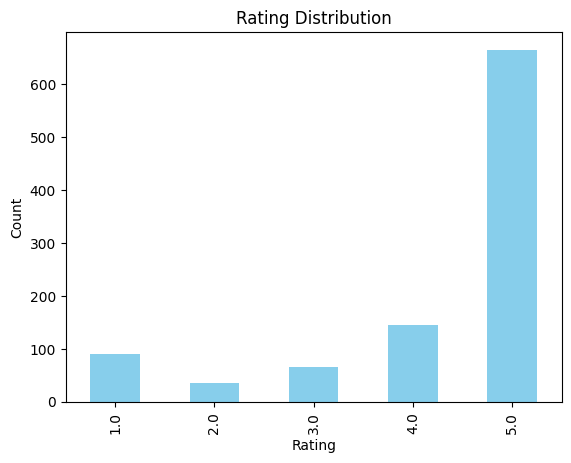

In [3]:
# Explore rating distribution
print("Rating Distribution:")
print(df['rating'].value_counts().sort_index())

# Plot
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [4]:
# Prepare data
df = prepare_review_data(df)

# Show example of preprocessing
print("Original vs Preprocessed Text:\n")
sample_idx = 0
print(f"Original:\n{df.iloc[sample_idx]['full_text']}")
print(f"\nProcessed:\n{df.iloc[sample_idx]['processed_text']}")
print(f"\nSentiment Label: {df.iloc[sample_idx]['sentiment_label']}")

Preprocessing 1000 reviews...
Extracting text features...
Prepared 1000 reviews for analysis
Original vs Preprocessed Text:

Original:
Smells like gasoline! Going back! First & most offensive: they reek of gasoline so if you are sensitive/allergic to petroleum products like I am you will want to pass on these.  Second: the phone adapter is useless as-is. Mine was not drilled far enough to be able to tighten it into place for my iPhone 12 max. It just slipped & slid all over. Stupid me putting the adapter together first without picking up the binoculars to smell them bc I wasted 15 minutes trying to figure out how to put the adapter together bc it does not come with instructions!  I had to come back here to the website which was a total pain. Third: the tripod is also useless. I would not trust the iOS to hold my $1600 phone nor even a Mattel Barbie for that matter. It’s just inefficient for the job imo.  Third: in order to try to give an honest review I did don gloves & eyewear to chec


Sentiment Distribution:
sentiment_label
positive    810
negative    125
neutral      65
Name: count, dtype: int64


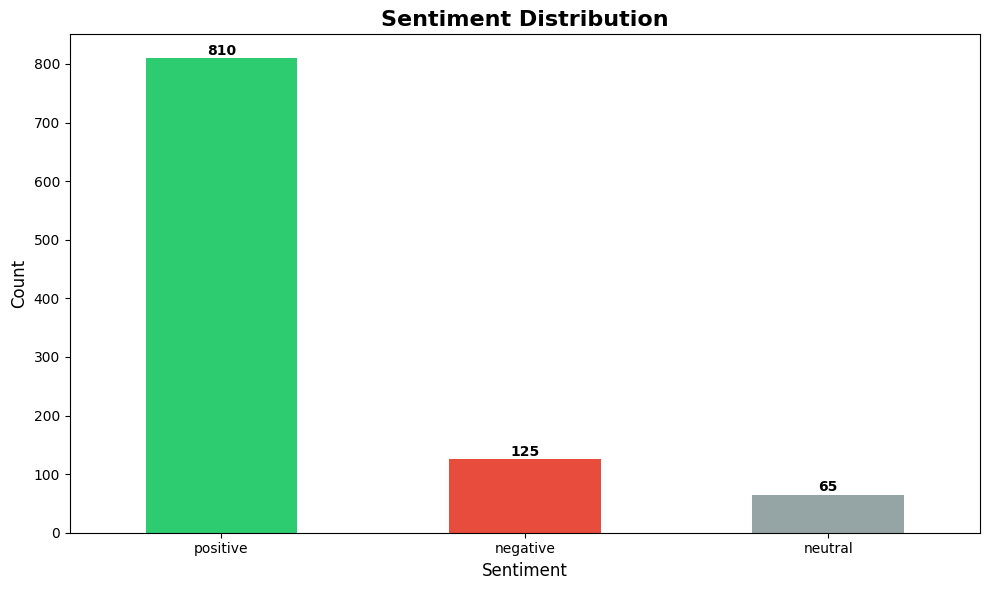

In [5]:
# View sentiment distribution
print("\nSentiment Distribution:")
print(df['sentiment_label'].value_counts())

# Visualize
viz = SentimentVisualizer()
viz.plot_sentiment_distribution(df, 'sentiment_label')
plt.show()

#### TF-IDF Sentiment Analysis

In [10]:
# Train TF-IDF model
tfidf_analyzer = TFIDFSentimentAnalyzer(classifier_type='logistic')

metrics = tfidf_analyzer.train(
    texts=df['processed_text'].tolist(),
    labels=df['sentiment_label'].tolist(),
    test_size=0.2
)

print(f"\nTF-IDF Model Performance:")
print(f"Test Accuracy: {metrics['test_accuracy']:.2%}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

Training TF-IDF logistic classifier...
Vectorizing text with TF-IDF...
TF-IDF matrix shape: (800, 5000)
Training logistic classifier...
Train Accuracy:	0.8562
Test Accuracy:	0.8150
Precision:	0.7844
Recall:	0.8150
F1 Score:	0.7366

TF-IDF Model Performance:
Test Accuracy: 81.50%
Precision: 0.7844
Recall: 0.8150
F1 Score: 0.7366


C:\Users\Shreya\.conda\envs\chia\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shreya\.conda\envs\chia\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shreya\.conda\envs\chia\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\U

In [11]:
# Show top features
top_features = tfidf_analyzer.get_top_features(n_features=10)

print("\nTop Predictive Features:\n")
for sentiment, features in top_features.items():
    print(f"{sentiment.upper()}: {', '.join(features)}")


Top Predictive Features:

NEGATIVE: one star, not, returned, no, did not, waste, junk, doe, did, return
NEUTRAL: three star, three, but, not, but it, protecting, this wa, not good, suck, better
POSITIVE: great, love, five, five star, good, my, work great, price, easy, love it


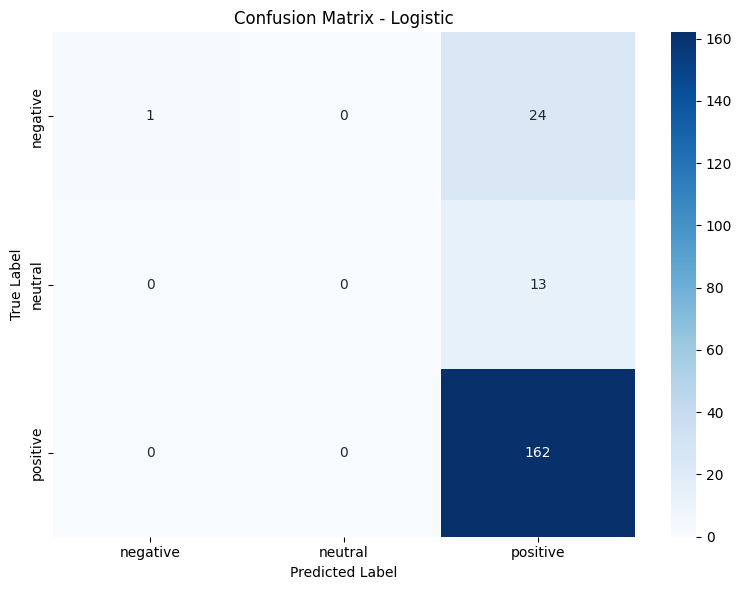

In [12]:
# Plot confusion matrix
tfidf_analyzer.plot_confusion_matrix()
plt.show()

In [13]:
# Test on new reviews
test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality. Broke after one day. Don't waste your money.",
    "It's okay, nothing special but does the job.",
    "Love it! Works perfectly and shipping was fast."
]

# Preprocess
preprocessor = TextPreprocessor()
processed_reviews = [preprocessor.preprocess(review) for review in test_reviews]

# Predict
predictions = tfidf_analyzer.predict(processed_reviews)

print("\nPredictions on New Reviews:\n")
for review, prediction in zip(test_reviews, predictions):
    print(f"Review: {review}")
    print(f"Sentiment: {prediction}\n")


Predictions on New Reviews:

Review: This product is absolutely amazing! Best purchase ever!
Sentiment: positive

Review: Terrible quality. Broke after one day. Don't waste your money.
Sentiment: negative

Review: It's okay, nothing special but does the job.
Sentiment: positive

Review: Love it! Works perfectly and shipping was fast.
Sentiment: positive



#### LLM-Based Analysis

In [14]:
# Initialize LLM analyzer (using smaller sample for speed)
df_sample = df.sample(n=min(200, len(df)), random_state=42)

llm_analyzer = LLMSentimentAnalyzer(model_name='distilbert')
df_sample = llm_analyzer.analyze_reviews(df_sample, text_column='full_text')

print("LLM Analysis complete!")

Loading model: distilbert-base-uncased-finetuned-sst-2-english
Device: GPU


Device set to use cuda:0


Model loaded successfully
Analyzing 200 reviews with distilbert...


Predicting: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.35it/s]

Analysis complete
LLM Analysis complete!


In [15]:
# Compare LLM with actual labels
from sklearn.metrics import accuracy_score, classification_report

llm_accuracy = accuracy_score(
    df_sample['sentiment_label'], 
    df_sample['llm_sentiment_normalized']
)

print(f"LLM Accuracy: {llm_accuracy:.2%}\n")
print("Classification Report:")
print(classification_report(
    df_sample['sentiment_label'], 
    df_sample['llm_sentiment_normalized']
))

LLM Accuracy: 78.00%

Classification Report:
              precision    recall  f1-score   support

    negative       0.35      0.92      0.51        24
     neutral       0.00      0.00      0.00        13
    positive       0.97      0.82      0.89       163

    accuracy                           0.78       200
   macro avg       0.44      0.58      0.47       200
weighted avg       0.83      0.78      0.79       200



C:\Users\Shreya\.conda\envs\chia\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shreya\.conda\envs\chia\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shreya\.conda\envs\chia\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Customer Insights

In [16]:
# Generate insights
summarizer = CustomerInsightSummarizer()
insights = summarizer.generate_product_insights(
    df,
    product_id='Electronics Sample',
    text_column='full_text'
)

# Create report
report = summarizer.create_txt_report(insights)
print(report)

Loading summarization model: facebook/bart-large-cnn


Device set to use cuda:0


Summarizer loaded
CUSTOMER FEEDBACK ANALYSIS REPORT

Product ID: Electronics Sample
Total Reviews Analyzed: 1000

Average Rating: 4.26/5.0

Sentiment Distribution:
  POSITIVE: 810 reviews (81.0%)
  NEGATIVE: 125 reviews (12.5%)
  NEUTRAL: 65 reviews (6.5%)

Positive Feedback Summary:
The sound and bass are awesome. Hands down my favorite headphones in this price bracket. I love the 1 click pause feature so i can quickly pause what i am listening to talk to someone (i don't have to go find my phone and swipe and pause). They are comfortable and stay on really well for my ears.

Negative Feedback Summary:
Not sure why this has good reviews. My devices had a hard time connecting This devices brought my wifi network to its knees. Didn’t work at all lenses loose/broken. Not very accurate in tracking steps taken. Wrist band started coming off after 3 months of use.

Most Frequent Topics:
  • great (463 mentions)
  • good (283 mentions)
  • br (282 mentions)
  • use (255 mentions)
  • just (2

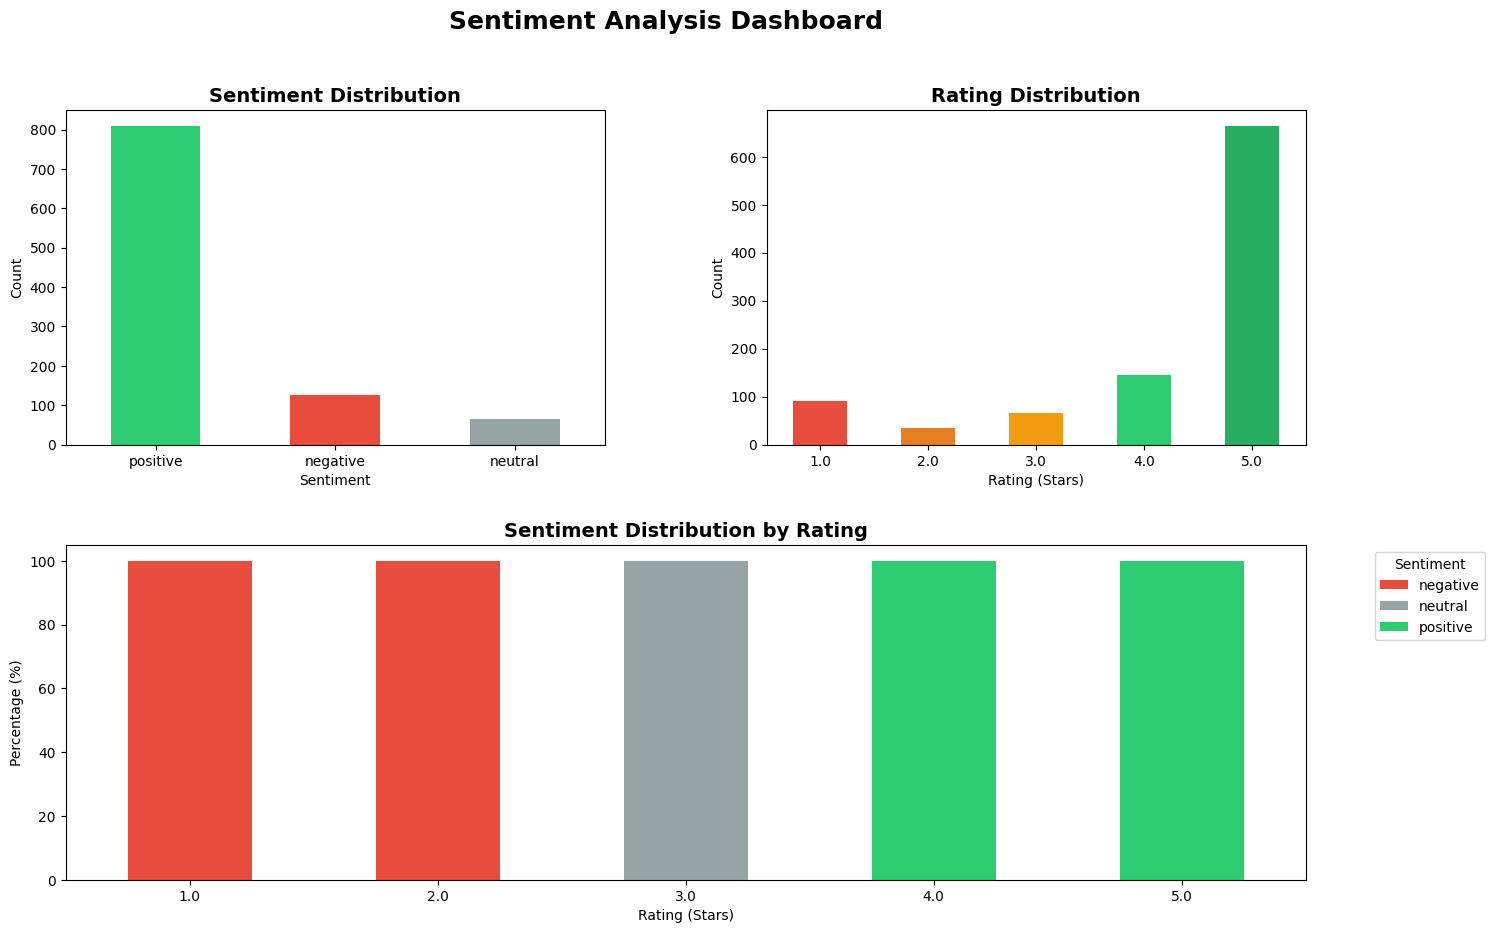

In [17]:
# Create dashboard
viz.create_dashboard(df, sentiment_column='sentiment_label')
plt.show()